In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx as nx
import time
import sys
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
from db.database import DatabaseConnector
from dtloader.dataloader import DataLoader
from failure_detector import *
from utils.utils import *
path = '../stats_files/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dl = DataLoader()
dl.load('sample.log')
dl.extractinfo(export=False,single_file=False)

mongodb://localhost:27017/
Database connected


# Sample Log Analysis

In [4]:
ts = {'RCIN':['C1','C2','C3','C4'] ,'AHR2':['Roll','Pitch','Alt','Yaw']}
df,df_corr = corr_var('sample.log',dl,ts)
df_corr.iloc[4:,:4]

,RCIN_C1,RCIN_C3,RCIN_C4,RCIN_C2
AHR2_Pitch,0.061377,-0.227663,0.202982,0.631013
AHR2_Yaw,0.060121,0.058846,-0.111098,-0.003648
AHR2_Alt,-0.009509,0.303141,-0.105879,-0.010000
AHR2_Roll,0.841028,-0.030206,0.501776,-0.018129


In [5]:
ts = {'MODE':['Mode'] ,'ERR':['Subsys']}
df,df_corr = corr_var('sample.log',dl,ts)
df_corr

,MODE_Mode,ERR_Subsys
MODE_Mode,1.000000,-0.522233
ERR_Subsys,-0.522233,1.000000


# All Logs - Mean Correlation - RCIN : AHR2

In [6]:
datalist =os.listdir('../data')

In [9]:
ts = {'RCIN':['C1','C2','C3','C4'] ,'AHR2':['Roll','Pitch','Alt','Yaw']}
print('File:{} --  {} / {}'.format(datalist[0],0,len(datalist)-1))
d,df_cnc = corr_var(datalist[0][:-4],dl,ts)
df_cnc = df_cnc.iloc[4:,:4]
count_list = []
for i,log in enumerate(datalist[1:]):
    print('File:{} --  {} / {}'.format(log,i+1,len(datalist)-1))
    count_novalues,df_corr = corr_var(log[:-4],dl,ts)
    if count_novalues != -1:
        df_cnc = pd.concat((df_cnc, df_corr.iloc[4:,:4]))
        count_list.append(count_novalues)
#compute the Mean 
by_row_index = df_cnc.groupby(df_cnc.index)
df_means = by_row_index.mean()
df_means

File:568c058bb560505c22dc402c.log --  0 / 2607
File:568c0b3a7132fa902e401d31.log --  1 / 2607
File:568c0db17132fa902e401d33.log --  2 / 2607
File:568c0e8f7132fa902e401d34.log --  3 / 2607
File:568c0f4a7132fa902e401d35.log --  4 / 2607
File:56d75dd746a12d150ba9724f.log --  5 / 2607
File:56d7e5a546a12d150ba97250.log --  6 / 2607
File:56f69d8d85e739af3b3cb422.log --  7 / 2607
File:56f6af5385e739af3b3cb424.log --  8 / 2607
File:56f6af5b85e739af3b3cb425.log --  9 / 2607
File:56f6af6885e739af3b3cb426.log --  10 / 2607
File:56f6af7385e739af3b3cb427.log --  11 / 2607
File:5757cf85cf913b9b04694227.log --  12 / 2607
No values in the component were found
File:5757d3dfcf913b9b04694228.log --  13 / 2607
No values in the component were found
File:5757d47fcf913b9b04694229.log --  14 / 2607
No values in the component were found
File:575ce9d988bc9002549dfb5e.log --  15 / 2607
No values in the component were found
File:575eaeb288bc9002549dfb5f.log --  16 / 2607
No values in the component were found
File

File:5768498172ee277c7e5a2453.log --  126 / 2607
No values in the component were found
File:5768ddd972ee277c7e5a2456.log --  127 / 2607
File:5768eeec477dabbb3415a7d8.log --  128 / 2607
No values in the component were found
File:57690d375f861dd84e5d53f8.log --  129 / 2607
File:57691f2e5f861dd84e5d53f9.log --  130 / 2607
No values in the component were found
File:576927a65f861dd84e5d53fa.log --  131 / 2607
File:57696a625f861dd84e5d53fd.log --  132 / 2607
No values in the component were found
File:57696b305f861dd84e5d53fe.log --  133 / 2607
No values in the component were found
File:57697fcf5f861dd84e5d53ff.log --  134 / 2607
No values in the component were found
File:576980851a680f491f2bbf1d.log --  135 / 2607
No values in the component were found
File:57698a6e1a680f491f2bbf1f.log --  136 / 2607
File:576a983bc25d5f525499820e.log --  137 / 2607
File:576b6771c25d5f525499820f.log --  138 / 2607
No values in the component were found
File:576b6b3cc25d5f5254998211.log --  139 / 2607
File:576b9

File:577bb31d6b67d3bd6633f4ea.log --  253 / 2607
File:577c1b646b67d3bd6633f4ec.log --  254 / 2607
No values in the component were found
File:577d52f75ea76af51d99646e.log --  255 / 2607
No values in the component were found
File:577d5b9d5ea76af51d996471.log --  256 / 2607
No values in the component were found
File:577d600a5ea76af51d996474.log --  257 / 2607
No values in the component were found
File:577ddca75ea76af51d996475.log --  258 / 2607
File:577e1a105ea76af51d996476.log --  259 / 2607
File:577e32a75ea76af51d996477.log --  260 / 2607
File:577e32b85ea76af51d996478.log --  261 / 2607
File:577e32c25ea76af51d996479.log --  262 / 2607
File:577e5e31e4db1be55b122497.log --  263 / 2607
File:577e60c9e4db1be55b122498.log --  264 / 2607
File:577e6268e4db1be55b12249b.log --  265 / 2607
File:577e6953e4db1be55b12249c.log --  266 / 2607
No values in the component were found
File:577e6a21e4db1be55b12249d.log --  267 / 2607
No values in the component were found
File:577e6a5de4db1be55b12249e.log -- 

File:578e5de03f58bbcd18ae0e6f.log --  371 / 2607
File:578ee0f7cb333a2711f75e3b.log --  372 / 2607
File:578f17631a5be0de76564541.log --  373 / 2607
File:578f18201a5be0de76564542.log --  374 / 2607
File:578f18771a5be0de76564543.log --  375 / 2607
File:578f559306e7bfad71cf22ee.log --  376 / 2607
No values in the component were found
File:578fadb5b26c057d302144f8.log --  377 / 2607
File:578fbb42b26c057d302144fb.log --  378 / 2607
No values in the component were found
File:578fbbd1b26c057d302144fd.log --  379 / 2607
No values in the component were found
File:5790a16f3fa528a871ce8bec.log --  380 / 2607
No values in the component were found
File:5790a1c53fa528a871ce8bee.log --  381 / 2607
No values in the component were found
File:5790a2a33fa528a871ce8bef.log --  382 / 2607
No values in the component were found
File:5790a3883fa528a871ce8bf0.log --  383 / 2607
No values in the component were found
File:5790a9ec3fa528a871ce8bf1.log --  384 / 2607
No values in the component were found
File:5790c

File:57a0cf8f3c40f4a35e8e49ad.log --  499 / 2607
File:57a19457a514289c28c2eaf0.log --  500 / 2607
File:57a1b56188940b1b4bb263b1.log --  501 / 2607
File:57a23ad90633f43526e7748d.log --  502 / 2607
No values in the component were found
File:57a23b8f0633f43526e7748e.log --  503 / 2607
No values in the component were found
File:57a23cdf0633f43526e7748f.log --  504 / 2607
No values in the component were found
File:57a2c9f357ad704631edfe64.log --  505 / 2607
File:57a2d5ec57ad704631edfe65.log --  506 / 2607
File:57a2d80f57ad704631edfe67.log --  507 / 2607
File:57a32d1592d5faed49428e7a.log --  508 / 2607
File:57a32da992d5faed49428e7b.log --  509 / 2607
File:57a32deb92d5faed49428e7c.log --  510 / 2607
File:57a32e1692d5faed49428e7d.log --  511 / 2607
File:57a38649ed540b986eee1312.log --  512 / 2607
No values in the component were found
File:57a38b0eed540b986eee1313.log --  513 / 2607
No values in the component were found
File:57a38b58ed540b986eee1315.log --  514 / 2607
No values in the component

File:57bab9a90380a26a5be8c1c8.log --  631 / 2607
No values in the component were found
File:57bad5500380a26a5be8c1c9.log --  632 / 2607
File:57baf2c10380a26a5be8c1ca.log --  633 / 2607
No values in the component were found
File:57bb2c927aac90ad3c4eff24.log --  634 / 2607
No values in the component were found
File:57bb32287aac90ad3c4eff25.log --  635 / 2607
File:57bb3c5c7aac90ad3c4eff26.log --  636 / 2607
File:57bbf2cf7eb8c7bd16574bdd.log --  637 / 2607
File:57bc2684021f5e4b12ebef7f.log --  638 / 2607
File:57bc270b021f5e4b12ebef80.log --  639 / 2607
File:57bc27ec021f5e4b12ebef81.log --  640 / 2607
File:57bd40ab6f975ee737242141.log --  641 / 2607
File:57bd6e8576af5e214ca13af4.log --  642 / 2607
File:57bd6f0b76af5e214ca13af5.log --  643 / 2607
File:57bd86963714df75705e52d7.log --  644 / 2607
File:57bd89943714df75705e52d9.log --  645 / 2607
File:57bdc11c3714df75705e52da.log --  646 / 2607
File:57be9768b529d37768023d06.log --  647 / 2607
No values in the component were found
File:57bebe413e

File:57d53efada5c3d0176af9b72.log --  751 / 2607
No values in the component were found
File:57d59322b5b6a40132b32b0b.log --  752 / 2607
No values in the component were found
File:57d5951bb5b6a40132b32b0c.log --  753 / 2607
No values in the component were found
File:57d5e3ce61d7e8e65ef2bd6d.log --  754 / 2607
No values in the component were found
File:57d5e84212efdf6f03b1bfc9.log --  755 / 2607
No values in the component were found
File:57d68a6393e68bf409301e83.log --  756 / 2607
File:57d6e56dacca982c0f138a90.log --  757 / 2607
No values in the component were found
File:57d7acc4eb3c75586ef97592.log --  758 / 2607
File:57d7b398eb3c75586ef97593.log --  759 / 2607
No values in the component were found
File:57d7f8a5699f5b396fee683a.log --  760 / 2607
File:57d7facc699f5b396fee683b.log --  761 / 2607
File:57d8641b7bafed6d7f35a4ab.log --  762 / 2607
File:57d8801f6d0a034862463184.log --  763 / 2607
File:57d94049de9386471a3073ae.log --  764 / 2607
No values in the component were found
File:57d99

File:57f690df1713fddc733233d4.log --  867 / 2607
No values in the component were found
File:57f691e01713fddc733233d5.log --  868 / 2607
File:57f6921d1713fddc733233d6.log --  869 / 2607
File:57f6a5361713fddc733233d7.log --  870 / 2607
File:57f6a5ec1713fddc733233d8.log --  871 / 2607
File:57f6b6d290e4f18001526302.log --  872 / 2607
File:57f6bae590e4f18001526303.log --  873 / 2607
File:57f7b542b0b5af9b0b2ec92e.log --  874 / 2607
No values in the component were found
File:57f7b638b0b5af9b0b2ec92f.log --  875 / 2607
No values in the component were found
File:57f7bd2ab0b5af9b0b2ec938.log --  876 / 2607
File:57f8247f8e1476d17645da57.log --  877 / 2607
File:57f8c67e35ed11d278b8a694.log --  878 / 2607
File:57fa153df6d311ba275f6cd5.log --  879 / 2607
No values in the component were found
File:57fa154ef6d311ba275f6cd6.log --  880 / 2607
No values in the component were found
File:57fa155bf6d311ba275f6cd7.log --  881 / 2607
No values in the component were found
File:57fbd5b425224fc2365c4b7f.log -- 

File:581759c7ce5002c15002808f.log --  997 / 2607
File:581775b1ce5002c150028090.log --  998 / 2607
File:5817aa50876192752f9a4f3a.log --  999 / 2607
File:5818da3db67d0a7b31ba941c.log --  1000 / 2607
File:5818dc4bb67d0a7b31ba941d.log --  1001 / 2607
File:5818e9adb67d0a7b31ba941e.log --  1002 / 2607
File:581a4326bdb4f91a1ea81110.log --  1003 / 2607
File:581c43ea441caaf431ebbf3b.log --  1004 / 2607
No values in the component were found
File:581c8b43ec09d8707f60855c.log --  1005 / 2607
No values in the component were found
File:581cff115cf1afd07cb2dd0c.log --  1006 / 2607
File:581cff8b5cf1afd07cb2dd0e.log --  1007 / 2607
File:581cffbf5cf1afd07cb2dd0f.log --  1008 / 2607
File:581cffe75cf1afd07cb2dd10.log --  1009 / 2607
File:581d000f5cf1afd07cb2dd11.log --  1010 / 2607
File:581d007d5cf1afd07cb2dd12.log --  1011 / 2607
File:581d5ef913a86b963f5fc522.log --  1012 / 2607
File:581d66d4b88c450562322674.log --  1013 / 2607
File:582035eab8feb1ae612f13b9.log --  1014 / 2607
File:5820de8d4b0e4d792b27e8

File:584ee04a0d9e85b91bb1ba64.log --  1132 / 2607
No values in the component were found
File:584ee0b30d9e85b91bb1ba66.log --  1133 / 2607
No values in the component were found
File:585114c1acabc92d18987d00.log --  1134 / 2607
No values in the component were found
File:5851150dacabc92d18987d01.log --  1135 / 2607
No values in the component were found
File:5851154facabc92d18987d02.log --  1136 / 2607
No values in the component were found
File:585120c1acabc92d18987d03.log --  1137 / 2607
File:58516fe2e0869aa5721f4396.log --  1138 / 2607
File:5853c514a73c2a0104bcaba0.log --  1139 / 2607
File:58542dafc3d625a46bf4848f.log --  1140 / 2607
No values in the component were found
File:585557211fe76ca408006888.log --  1141 / 2607
File:585558719616ecc915a248ff.log --  1142 / 2607
No values in the component were found
File:58567764442ad4433fe1ba06.log --  1143 / 2607
No values in the component were found
File:5856c4db58dd094539cd0beb.log --  1144 / 2607
No values in the component were found
File:585

File:58a05aa05848955171dbb240.log --  1255 / 2607
File:58a0d3e7f0fafb1573d98778.log --  1256 / 2607
File:58a0d449f0fafb1573d98779.log --  1257 / 2607
File:58a0d495f0fafb1573d9877a.log --  1258 / 2607
File:58a0d8bab98d006e08d17bd9.log --  1259 / 2607
No values in the component were found
File:58a18b66f9afc0476fc8f238.log --  1260 / 2607
File:58a19aaa4548148a3689779d.log --  1261 / 2607
File:58a1f1e3270b088b448d9f71.log --  1262 / 2607
No values in the component were found
File:58a44d5ddc870752683e8c82.log --  1263 / 2607
No values in the component were found
File:58a4568e5d29ae1e114076d3.log --  1264 / 2607
File:58a69ab554ab26b626a5e567.log --  1265 / 2607
File:58a6eb5e1e01369a7c9dd698.log --  1266 / 2607
File:58a6ef29ff7879f45903f296.log --  1267 / 2607
File:58a85c2f13fc18aa55c71ccd.log --  1268 / 2607
File:58a86873740f56d00330f099.log --  1269 / 2607
File:58a88beb97e1e1611c99665b.log --  1270 / 2607
File:58a88d4fbc6d01ae206e4509.log --  1271 / 2607
File:58a88ddfbc6d01ae206e450a.log --

File:58d34680e75884dd1efd0030.log --  1384 / 2607
File:58d3e819bec411bc243b6487.log --  1385 / 2607
No values in the component were found
File:58d3fcf7b059ee5b0ae4d639.log --  1386 / 2607
File:58d3fd815601daff0f080f95.log --  1387 / 2607
No values in the component were found
File:58d564354320fe904cfec870.log --  1388 / 2607
No values in the component were found
File:58d64232cfb07c0e3fe66495.log --  1389 / 2607
File:58d6567fcfb07c0e3fe66496.log --  1390 / 2607
No values in the component were found
File:58d657f5cfb07c0e3fe66497.log --  1391 / 2607
No values in the component were found
File:58d67b66bdacb4bc30d4d408.log --  1392 / 2607
No values in the component were found
File:58d67c3ebdacb4bc30d4d409.log --  1393 / 2607
No values in the component were found
File:58d67c50bdacb4bc30d4d40a.log --  1394 / 2607
No values in the component were found
File:58d67c7cbdacb4bc30d4d40b.log --  1395 / 2607
No values in the component were found
File:58d67ca86add8ca84ff6d5d4.log --  1396 / 2607
No value

No values in the component were found
File:58fdec563eb8dc015649d893.log --  1525 / 2607
No values in the component were found
File:58fe38daba797985178036e2.log --  1526 / 2607
File:58fe51ad93075ee84d66238e.log --  1527 / 2607
File:58fe6184b0d9f3517f5b6854.log --  1528 / 2607
File:58feee866b8d45326db551f2.log --  1529 / 2607
No values in the component were found
File:58feeec6f40999ac70709cc6.log --  1530 / 2607
No values in the component were found
File:58ff09af8a50e25b1624a1b3.log --  1531 / 2607
File:58ff48260f0cb889479bb914.log --  1532 / 2607
File:58ff66180f0cb889479bb915.log --  1533 / 2607
File:58ff74757e6243073ad1e8a6.log --  1534 / 2607
No values in the component were found
File:58ff759d7e6243073ad1e8a7.log --  1535 / 2607
No values in the component were found
File:58ff76577e6243073ad1e8aa.log --  1536 / 2607
No values in the component were found
File:58ffbf5342f5219f22a2e4b4.log --  1537 / 2607
File:59001e56ffc8597030be7294.log --  1538 / 2607
No values in the component were fo

File:591378ec81ffca9221396328.log --  1667 / 2607
File:5913a89f46cbe5f6565c42fe.log --  1668 / 2607
File:5914346a4416eae5459ddd86.log --  1669 / 2607
File:591435414416eae5459ddd87.log --  1670 / 2607
File:5914589859c7856719eebcb6.log --  1671 / 2607
File:5914a451ef0e06575976aef3.log --  1672 / 2607
No values in the component were found
File:5914cda5b9d6c7ae4e76c2ce.log --  1673 / 2607
File:5914d22cfeaf72976233f8a3.log --  1674 / 2607
File:5914d9b566b6daa766eae6ea.log --  1675 / 2607
File:59155290fbcab4f6290090d3.log --  1676 / 2607
File:59155333fbcab4f6290090d4.log --  1677 / 2607
File:59155373fbcab4f6290090d5.log --  1678 / 2607
File:5915539efbcab4f6290090d6.log --  1679 / 2607
File:591553d8fbcab4f6290090d7.log --  1680 / 2607
File:591583084d1d09ac7b01c2de.log --  1681 / 2607
No values in the component were found
File:5915857d8c1d0d3a2eb2be8a.log --  1682 / 2607
No values in the component were found
File:5915b738572f6aab197c1943.log --  1683 / 2607
File:5915b814572f6aab197c1944.log --

File:5921f50d67016b1802829240.log --  1811 / 2607
File:5921f5f267016b1802829242.log --  1812 / 2607
File:59229477e5c46d0053f91ced.log --  1813 / 2607
File:5922969ce5c46d0053f91cef.log --  1814 / 2607
File:5922af2afa8fd04911ee4c79.log --  1815 / 2607
File:5922e931f358fdbe1c224d8d.log --  1816 / 2607
File:592356afe75a874e4cf9e4fb.log --  1817 / 2607
File:5923f67fa369e231612322d4.log --  1818 / 2607
File:59241b382183ce9321981735.log --  1819 / 2607
File:59241e99798eca2753efa5b4.log --  1820 / 2607
File:59244420fea6c7f37c6b4491.log --  1821 / 2607
File:592464bf737ddeae6c061e96.log --  1822 / 2607
File:59246b47b3dd98a71726a32f.log --  1823 / 2607
File:592480683e787d3349e9c466.log --  1824 / 2607
No values in the component were found
File:5924c0ad902d3d837bdbb0c5.log --  1825 / 2607
File:5924c49a902d3d837bdbb0c6.log --  1826 / 2607
File:59254e64455246b16fc5d611.log --  1827 / 2607
File:592582e8715428cc767973e3.log --  1828 / 2607
File:5925842379ee973b0190d39c.log --  1829 / 2607
File:592598a

File:5942c9faa08b10cd45423204.log --  1950 / 2607
File:5942d1f2a08b10cd45423205.log --  1951 / 2607
File:5942dfc28723591604f7756b.log --  1952 / 2607
File:5942e68c8723591604f7756c.log --  1953 / 2607
File:59433aaa22c5f09816604b2e.log --  1954 / 2607
No values in the component were found
File:59436048ad3ea37d2846e87d.log --  1955 / 2607
File:5943716c19c0cf637cf7e3f9.log --  1956 / 2607
No values in the component were found
File:5943736a19c0cf637cf7e3fa.log --  1957 / 2607
No values in the component were found
File:59437b3ca23d0ce8150119ae.log --  1958 / 2607
No values in the component were found
File:5943adc4372ebcdf0e7b9f57.log --  1959 / 2607
File:59441559c2aedfe72becdfaa.log --  1960 / 2607
File:594500ba40819c1f6093ed05.log --  1961 / 2607
No values in the component were found
File:59456bb4f57ed33e196e83c9.log --  1962 / 2607
File:59456c91f57ed33e196e83ca.log --  1963 / 2607
File:594585d7166e2dce33db930a.log --  1964 / 2607
File:5945865c166e2dce33db930b.log --  1965 / 2607
File:59458

File:595c1636ca139e76642338e4.log --  2085 / 2607
File:595d3f59b38f71136f0e84a0.log --  2086 / 2607
File:595d47c9b38f71136f0e84a1.log --  2087 / 2607
File:595d4c32fc880a7913f3a08a.log --  2088 / 2607
File:595d50b6fc880a7913f3a08b.log --  2089 / 2607
File:595d51f7a72e8d0e2d61637e.log --  2090 / 2607
File:595e5bfae8c6778c75b8d595.log --  2091 / 2607
File:595e84736383a67f1f7e4f41.log --  2092 / 2607
File:595e88e56383a67f1f7e4f42.log --  2093 / 2607
File:595e8dfd6383a67f1f7e4f43.log --  2094 / 2607
File:595e93c86383a67f1f7e4f44.log --  2095 / 2607
File:595e9d220a79ac1b085e76b6.log --  2096 / 2607
File:595f487b81e0097133828012.log --  2097 / 2607
No values in the component were found
File:595f495381e0097133828013.log --  2098 / 2607
No values in the component were found
File:595f495a81e0097133828014.log --  2099 / 2607
No values in the component were found
File:5960a7cb8f15edd158ad91c4.log --  2100 / 2607
File:5960aafe1895cd15693ece8c.log --  2101 / 2607
File:5960af8b1895cd15693ece8d.log --

File:5974f2a7b92d7954428b0c8d.log --  2216 / 2607
File:5974f2edb92d7954428b0c8e.log --  2217 / 2607
File:5974f39847725cae450eb2a6.log --  2218 / 2607
File:5974f63b47725cae450eb2a7.log --  2219 / 2607
File:5974f65447725cae450eb2a8.log --  2220 / 2607
File:5974f67d47725cae450eb2a9.log --  2221 / 2607
File:5974f6e047725cae450eb2aa.log --  2222 / 2607
File:5974fb38f3e709e158886800.log --  2223 / 2607
File:5974fc2df3e709e158886802.log --  2224 / 2607
File:5974fe39f3e709e158886806.log --  2225 / 2607
File:5974fe4df3e709e158886807.log --  2226 / 2607
File:5974fe72f3e709e158886808.log --  2227 / 2607
File:5974fe8df3e709e158886809.log --  2228 / 2607
File:5974fefef3e709e15888680d.log --  2229 / 2607
File:5975aa754cc2593335d9fe30.log --  2230 / 2607
File:5975e59438f03d5c5b463f83.log --  2231 / 2607
No values in the component were found
File:5975e5dc38f03d5c5b463f84.log --  2232 / 2607
No values in the component were found
File:59762d7d097194c508c8c489.log --  2233 / 2607
File:597692760f62d6ae24f

File:598f1dedc15f6407723ab80b.log --  2353 / 2607
File:598f21e980e088b32740e38b.log --  2354 / 2607
No values in the component were found
File:598f220280e088b32740e38c.log --  2355 / 2607
No values in the component were found
File:598f224e80e088b32740e38d.log --  2356 / 2607
No values in the component were found
File:598f5d57d718112646f5d71b.log --  2357 / 2607
No values in the component were found
File:598ff4eb0efd4d834ae332e4.log --  2358 / 2607
File:599036500c98b00e7c99eef8.log --  2359 / 2607
File:59905a9678b282246b07ad40.log --  2360 / 2607
File:599088dadc305d7d686ea03e.log --  2361 / 2607
File:5990890c3116253d6a06b87b.log --  2362 / 2607
File:599089867a5100fe6a8ad5d3.log --  2363 / 2607
File:5990a34a4ec89de0197e1e1e.log --  2364 / 2607
File:5991326fffafb18e05b49b0b.log --  2365 / 2607
File:59913441ffafb18e05b49b0d.log --  2366 / 2607
File:599134a206533e4733a58c40.log --  2367 / 2607
File:599134f406533e4733a58c42.log --  2368 / 2607
File:59914a784c07a6bc3d81d57f.log --  2369 / 260

No values in the component were found
File:59dd25e481e35e8031d8beab.log --  2498 / 2607
No values in the component were found
File:59dd260281e35e8031d8beac.log --  2499 / 2607
No values in the component were found
File:59dd261d81e35e8031d8bead.log --  2500 / 2607
No values in the component were found
File:59dd264881e35e8031d8beae.log --  2501 / 2607
No values in the component were found
File:59dd275781e35e8031d8beb1.log --  2502 / 2607
No values in the component were found
File:59de8290b04ea7f84a7bf912.log --  2503 / 2607
File:59e1fc091cf7a26414a47b0a.log --  2504 / 2607
File:59e289bea845592b3064a142.log --  2505 / 2607
No values in the component were found
File:59e28a32a845592b3064a143.log --  2506 / 2607
File:59e2fd5666347b911b363308.log --  2507 / 2607
File:59e2fdfa66347b911b363309.log --  2508 / 2607
File:59e341f480b2d8f41ff14fe4.log --  2509 / 2607
No values in the component were found
File:59e36bfa72aeff3c5396f5f0.log --  2510 / 2607
File:59e3900d6bbe644a335b7365.log --  2511 / 2

,AHR2_Alt,AHR2_Pitch,AHR2_Roll,AHR2_Yaw,RCIN_C1,RCIN_C2,RCIN_C3,RCIN_C4
AHR2_Alt,NaN,NaN,NaN,NaN,-0.005291,-0.030354,0.235286,0.004890
AHR2_Pitch,NaN,NaN,NaN,NaN,-0.006576,0.330739,-0.010928,0.004373
AHR2_Roll,NaN,NaN,NaN,NaN,0.342410,0.001655,-0.016534,0.033660
AHR2_Yaw,NaN,NaN,NaN,NaN,-0.000045,-0.010622,0.030861,-0.001218


In [10]:
df_means.dropna(axis=1,how='all')

,RCIN_C1,RCIN_C2,RCIN_C3,RCIN_C4
AHR2_Alt,-0.005291,-0.030354,0.235286,0.004890
AHR2_Pitch,-0.006576,0.330739,-0.010928,0.004373
AHR2_Roll,0.342410,0.001655,-0.016534,0.033660
AHR2_Yaw,-0.000045,-0.010622,0.030861,-0.001218


In [11]:
print('Mean Number of variables not found in log files : ',np.mean(count_list))

Mean Number of variables not found in log files :  0.6272965879265092


# Top 100 Variables Correlation Table

In [14]:
df = load_top100()
#put the var in the right form for the method input
vardict = load_top100_dict()

In [15]:
#Creating 100x100 correlation table
df_cnc= pd.DataFrame({'temp':[0]}) #init table
time_list = []
for i,log in enumerate(datalist):
    start_time = time.time()
    print('File:{} --  {} / {}'.format(log,i,len(datalist)-1))
    _,df_corr = corr_var(log[:-4],dl,vardict)
    if _ != -1:
        df_cnc = pd.concat((df_cnc, df_corr))
        time_list.append((log,os.path.getsize('../data/'+log)/1000000,time.time() - start_time))
    else:
        continue
by_row_index = df_cnc.groupby(df_cnc.index)
df_means = by_row_index.mean()
df_means.drop([0],inplace=True)
df_means.drop('temp',axis=1,inplace=True)
print(df_means.shape)

File:568c058bb560505c22dc402c.log --  0 / 2607
File:568c0b3a7132fa902e401d31.log --  1 / 2607
File:568c0db17132fa902e401d33.log --  2 / 2607
File:568c0e8f7132fa902e401d34.log --  3 / 2607
File:568c0f4a7132fa902e401d35.log --  4 / 2607
File:56d75dd746a12d150ba9724f.log --  5 / 2607
File:56d7e5a546a12d150ba97250.log --  6 / 2607
File:56f69d8d85e739af3b3cb422.log --  7 / 2607
File:56f6af5385e739af3b3cb424.log --  8 / 2607
File:56f6af5b85e739af3b3cb425.log --  9 / 2607
File:56f6af6885e739af3b3cb426.log --  10 / 2607
File:56f6af7385e739af3b3cb427.log --  11 / 2607
File:5757cf85cf913b9b04694227.log --  12 / 2607
File:5757d3dfcf913b9b04694228.log --  13 / 2607
File:5757d47fcf913b9b04694229.log --  14 / 2607
File:575ce9d988bc9002549dfb5e.log --  15 / 2607
File:575eaeb288bc9002549dfb5f.log --  16 / 2607
File:575ec43488bc9002549dfb60.log --  17 / 2607
File:575ed0b988bc9002549dfb61.log --  18 / 2607
File:575ed0f588bc9002549dfb64.log --  19 / 2607
File:575ed3b888bc9002549dfb65.log --  20 / 2607
Fi

File:576f8ce4b58bef241a2c9854.log --  169 / 2607
File:576f963cb58bef241a2c9855.log --  170 / 2607
File:576fdb91b58bef241a2c9856.log --  171 / 2607
File:576fe457d10258b12c9135be.log --  172 / 2607
File:5770343ed10258b12c9135c0.log --  173 / 2607
File:5770b23d1fe81168033785e4.log --  174 / 2607
File:5771016e1fe81168033785e5.log --  175 / 2607
File:577143ae1fe81168033785e6.log --  176 / 2607
File:577149121fe81168033785ec.log --  177 / 2607
File:5771703c1fe81168033785ed.log --  178 / 2607
File:57718e882e6685cc214ae111.log --  179 / 2607
File:57718f052e6685cc214ae112.log --  180 / 2607
File:577192912e6685cc214ae115.log --  181 / 2607
File:5771a5792e6685cc214ae117.log --  182 / 2607
File:5771a66bc20e35fd4cb0fc8c.log --  183 / 2607
File:577238afb8d71d6901d96ad2.log --  184 / 2607
File:5772aea0b8d71d6901d96ad5.log --  185 / 2607
File:5772becd034eae436b42b979.log --  186 / 2607
File:5772c9db034eae436b42b981.log --  187 / 2607
File:577388f6809d6dd7233bd0ee.log --  188 / 2607
File:5773894cb1de4ac

File:578a4973512e4c801b556ec1.log --  337 / 2607
File:578a49c6512e4c801b556ec2.log --  338 / 2607
File:578a88eb70d64c2d0cb0b789.log --  339 / 2607
File:578a893270d64c2d0cb0b78a.log --  340 / 2607
File:578a898070d64c2d0cb0b78b.log --  341 / 2607
File:578a8b0c70d64c2d0cb0b78f.log --  342 / 2607
File:578b1f312774d3b31bd2dbd5.log --  343 / 2607
File:578b1f942774d3b31bd2dbd6.log --  344 / 2607
File:578b1ffb2774d3b31bd2dbd7.log --  345 / 2607
File:578b67b1dec68d064b1400cb.log --  346 / 2607
File:578ba512b5c94d575e867259.log --  347 / 2607
File:578bcbcea56e1343709df030.log --  348 / 2607
File:578bcf10a56e1343709df032.log --  349 / 2607
File:578bcf9ca56e1343709df033.log --  350 / 2607
No values in the component were found
File:578bd0dfa56e1343709df034.log --  351 / 2607
No values in the component were found
File:578c4e28e6f0ee8f5b5e3a84.log --  352 / 2607
File:578ca61aa023a7f75c683e49.log --  353 / 2607
File:578cb727f7e7e2520ce3f099.log --  354 / 2607
File:578cb7adf7e7e2520ce3f09a.log --  355 

File:57a23b8f0633f43526e7748e.log --  503 / 2607
File:57a23cdf0633f43526e7748f.log --  504 / 2607
File:57a2c9f357ad704631edfe64.log --  505 / 2607
File:57a2d5ec57ad704631edfe65.log --  506 / 2607
File:57a2d80f57ad704631edfe67.log --  507 / 2607
File:57a32d1592d5faed49428e7a.log --  508 / 2607
File:57a32da992d5faed49428e7b.log --  509 / 2607
File:57a32deb92d5faed49428e7c.log --  510 / 2607
File:57a32e1692d5faed49428e7d.log --  511 / 2607
File:57a38649ed540b986eee1312.log --  512 / 2607
File:57a38b0eed540b986eee1313.log --  513 / 2607
File:57a38b58ed540b986eee1315.log --  514 / 2607
File:57a38d41ed540b986eee1316.log --  515 / 2607
File:57a39776ed540b986eee1317.log --  516 / 2607
File:57a39a6eed540b986eee1319.log --  517 / 2607
File:57a3ee10de0960b913bb37e7.log --  518 / 2607
File:57a3ee24de0960b913bb37e8.log --  519 / 2607
File:57a41ba8de0960b913bb37e9.log --  520 / 2607
File:57a41beade0960b913bb37ea.log --  521 / 2607
File:57a46ad6ba5f034674aed62b.log --  522 / 2607
File:57a46c2cba5f034

File:57c2153c805c6dec2c5a87d5.log --  670 / 2607
File:57c2a0dc9a85f46961a05f1d.log --  671 / 2607
File:57c31b771ff2f25c1bd2b0e3.log --  672 / 2607
File:57c326631ff2f25c1bd2b0e4.log --  673 / 2607
File:57c330561ff2f25c1bd2b0e5.log --  674 / 2607
File:57c349a106ef97a328c5f438.log --  675 / 2607
File:57c34d4f06ef97a328c5f43a.log --  676 / 2607
File:57c34e6406ef97a328c5f43b.log --  677 / 2607
File:57c34ef006ef97a328c5f43c.log --  678 / 2607
File:57c350f206ef97a328c5f43d.log --  679 / 2607
File:57c3d318950e98b1125c8abf.log --  680 / 2607
File:57c4104b7d754c5d3614e9fd.log --  681 / 2607
File:57c4467ae59662874770e8ad.log --  682 / 2607
File:57c57c7779eee4d643ad3406.log --  683 / 2607
File:57c5ac6879eee4d643ad3408.log --  684 / 2607
File:57c5bf7579eee4d643ad3409.log --  685 / 2607
File:57c5c3cc79eee4d643ad340c.log --  686 / 2607
File:57c5d2b879eee4d643ad340d.log --  687 / 2607
File:57c698ed79eee4d643ad340f.log --  688 / 2607
File:57c699a379eee4d643ad3410.log --  689 / 2607
File:57c7038b92e659c

File:57efded1203a05f7684d8afc.log --  837 / 2607
File:57eff07a8dab47cc4b92f176.log --  838 / 2607
File:57eff0d28dab47cc4b92f177.log --  839 / 2607
File:57eff1028dab47cc4b92f178.log --  840 / 2607
File:57eff1418dab47cc4b92f179.log --  841 / 2607
File:57f00140ba192c26390a0f0c.log --  842 / 2607
File:57f0025d9d4ca6113c6b869a.log --  843 / 2607
File:57f0aa75c1c0a3372d15c57d.log --  844 / 2607
File:57f0c55fc1c0a3372d15c57f.log --  845 / 2607
File:57f11e37f9211a04366d307a.log --  846 / 2607
File:57f1841e151c9b89624f878e.log --  847 / 2607
File:57f210a093fe46b12cf849a1.log --  848 / 2607
File:57f234ca93fe46b12cf849a2.log --  849 / 2607
File:57f2acd3434e763f59604ee5.log --  850 / 2607
File:57f2ad77434e763f59604ee7.log --  851 / 2607
File:57f2af33434e763f59604eeb.log --  852 / 2607
File:57f2b21d434e763f59604eec.log --  853 / 2607
File:57f37da81bce9bc9417d35d4.log --  854 / 2607
File:57f3b8db947b48154efed1d5.log --  855 / 2607
File:57f3b948947b48154efed1d6.log --  856 / 2607
File:57f403a07339b3a

File:581a4326bdb4f91a1ea81110.log --  1003 / 2607
File:581c43ea441caaf431ebbf3b.log --  1004 / 2607
File:581c8b43ec09d8707f60855c.log --  1005 / 2607
File:581cff115cf1afd07cb2dd0c.log --  1006 / 2607
File:581cff8b5cf1afd07cb2dd0e.log --  1007 / 2607
File:581cffbf5cf1afd07cb2dd0f.log --  1008 / 2607
File:581cffe75cf1afd07cb2dd10.log --  1009 / 2607
File:581d000f5cf1afd07cb2dd11.log --  1010 / 2607
File:581d007d5cf1afd07cb2dd12.log --  1011 / 2607
File:581d5ef913a86b963f5fc522.log --  1012 / 2607
File:581d66d4b88c450562322674.log --  1013 / 2607
File:582035eab8feb1ae612f13b9.log --  1014 / 2607
File:5820de8d4b0e4d792b27e813.log --  1015 / 2607
File:5822031a095d0c4e4dc69e2d.log --  1016 / 2607
File:5823467ffc2e9d450b639944.log --  1017 / 2607
File:582346e1fc2e9d450b639945.log --  1018 / 2607
File:5823470bfc2e9d450b639946.log --  1019 / 2607
File:5823472afc2e9d450b639947.log --  1020 / 2607
File:582362ebfc2e9d450b639948.log --  1021 / 2607
File:582377c7fc2e9d450b639949.log --  1022 / 2607


File:58691a1f3b6601692c87ab66.log --  1167 / 2607
File:58692e14382601a1241366b4.log --  1168 / 2607
File:58692e82382601a1241366b5.log --  1169 / 2607
File:586a4eebe5dccbe54bcab625.log --  1170 / 2607
File:586a5654e5dccbe54bcab626.log --  1171 / 2607
File:586ab1e55727e2443c18d3c8.log --  1172 / 2607
File:586c2508466c3ab75de6f183.log --  1173 / 2607
File:586cc9d239682c1d13aa3f8e.log --  1174 / 2607
File:586cc9ec39682c1d13aa3f8f.log --  1175 / 2607
File:586cfbe945e9d5d762d53a8e.log --  1176 / 2607
File:586e371fa6efadd60e1b113e.log --  1177 / 2607
File:586f619dba4e9a7369b5ccce.log --  1178 / 2607
File:586f92e8f0aba3733457324f.log --  1179 / 2607
File:58714a6075a7d9544e52684d.log --  1180 / 2607
File:58714c7f15b927dd50d9b8b6.log --  1181 / 2607
File:5871514e65bab74f6bf08340.log --  1182 / 2607
File:5872873e4d0334f564523cd8.log --  1183 / 2607
File:587304f21a25823e4f47afe6.log --  1184 / 2607
File:587305e61a25823e4f47afe7.log --  1185 / 2607
File:5873062a1a25823e4f47afe8.log --  1186 / 2607


File:58c28d4d3381ad1402155a51.log --  1331 / 2607
File:58c2995d3feb0c652df06f5d.log --  1332 / 2607
File:58c2c23946e7af9a5eec93b0.log --  1333 / 2607
File:58c2d583ff73d7442a6e9e0d.log --  1334 / 2607
File:58c3e69a03d9b00f21696b11.log --  1335 / 2607
File:58c4171f1981816b6eec5cce.log --  1336 / 2607
File:58c4250f3208d27c2d79094e.log --  1337 / 2607
File:58c462f770803aed3b6035d4.log --  1338 / 2607
File:58c48995392d1fe461c0348d.log --  1339 / 2607
File:58c4d01626303a540f54965d.log --  1340 / 2607
File:58c52ebfe2b5058d1f24c544.log --  1341 / 2607
File:58c52f08e2b5058d1f24c545.log --  1342 / 2607
File:58c52f528b082195237a69ab.log --  1343 / 2607
File:58c555f37186c6dd42008ac7.log --  1344 / 2607
File:58c5565c04bde47a430627c5.log --  1345 / 2607
File:58c5702001250fbf2fe466d1.log --  1346 / 2607
File:58c570cb0801fa9233d4ccac.log --  1347 / 2607
File:58c571550801fa9233d4ccad.log --  1348 / 2607
File:58c5717f0801fa9233d4ccae.log --  1349 / 2607
File:58c5c62a23ede42b19512263.log --  1350 / 2607


File:58f78216512d7e5d1d934e13.log --  1493 / 2607
File:58f78309512d7e5d1d934e14.log --  1494 / 2607
File:58f7afadc7f537e21e115a6d.log --  1495 / 2607
File:58fa187383d55f9b619b28db.log --  1496 / 2607
File:58fa1eceb4efda84788f070d.log --  1497 / 2607
No values in the component were found
File:58fa2f3ab4efda84788f070e.log --  1498 / 2607
File:58fb2873b9cdd0490cc758f6.log --  1499 / 2607
File:58fb2fd2a79dd0da3ec2ae94.log --  1500 / 2607
File:58fb366ba79dd0da3ec2ae95.log --  1501 / 2607
File:58fb406ba79dd0da3ec2ae97.log --  1502 / 2607
File:58fb4676a79dd0da3ec2ae99.log --  1503 / 2607
File:58fb4fe6f70159e1128691e2.log --  1504 / 2607
File:58fb5098f70159e1128691e3.log --  1505 / 2607
File:58fb52acf70159e1128691e4.log --  1506 / 2607
File:58fb6e840b6f301c4d38d157.log --  1507 / 2607
File:58fb8f449ae722fa2d527771.log --  1508 / 2607
File:58fbb85a9ae722fa2d527773.log --  1509 / 2607
File:58fc68e7ceac839363b05916.log --  1510 / 2607
File:58fc69b8ceac839363b05917.log --  1511 / 2607
File:58fc760

File:5912452334847e1d2db19128.log --  1656 / 2607
File:5912a1a306f43bcc0f9baa57.log --  1657 / 2607
File:5912a1e406f43bcc0f9baa58.log --  1658 / 2607
File:5912a23406f43bcc0f9baa59.log --  1659 / 2607
File:5912df184dd84f2b08972b6f.log --  1660 / 2607
File:5912df2d4dd84f2b08972b70.log --  1661 / 2607
File:5912df3d4dd84f2b08972b71.log --  1662 / 2607
File:591301c0640019d50bfbedf7.log --  1663 / 2607
File:5913366a921e22e639ea1db1.log --  1664 / 2607
File:59133696921e22e639ea1db2.log --  1665 / 2607
File:5913775b81ffca9221396327.log --  1666 / 2607
File:591378ec81ffca9221396328.log --  1667 / 2607
File:5913a89f46cbe5f6565c42fe.log --  1668 / 2607
File:5914346a4416eae5459ddd86.log --  1669 / 2607
File:591435414416eae5459ddd87.log --  1670 / 2607
File:5914589859c7856719eebcb6.log --  1671 / 2607
File:5914a451ef0e06575976aef3.log --  1672 / 2607
File:5914cda5b9d6c7ae4e76c2ce.log --  1673 / 2607
File:5914d22cfeaf72976233f8a3.log --  1674 / 2607
File:5914d9b566b6daa766eae6ea.log --  1675 / 2607


File:59241e99798eca2753efa5b4.log --  1820 / 2607
File:59244420fea6c7f37c6b4491.log --  1821 / 2607
File:592464bf737ddeae6c061e96.log --  1822 / 2607
File:59246b47b3dd98a71726a32f.log --  1823 / 2607
File:592480683e787d3349e9c466.log --  1824 / 2607
File:5924c0ad902d3d837bdbb0c5.log --  1825 / 2607
File:5924c49a902d3d837bdbb0c6.log --  1826 / 2607
File:59254e64455246b16fc5d611.log --  1827 / 2607
File:592582e8715428cc767973e3.log --  1828 / 2607
File:5925842379ee973b0190d39c.log --  1829 / 2607
File:592598aa234864120ec9eb33.log --  1830 / 2607
File:5925cab89df64b5a0fe7ef0d.log --  1831 / 2607
File:592762d6a53c75b70efda838.log --  1832 / 2607
File:5927ecc1bcb428ee33d3dfcc.log --  1833 / 2607
File:59282f2d599c32645c9574f3.log --  1834 / 2607
File:5928730b7d7018857d4c244e.log --  1835 / 2607
File:59288760d45f4831503ede9e.log --  1836 / 2607
File:5929ad4ba29395d02cb65f31.log --  1837 / 2607
File:5929ada7a29395d02cb65f32.log --  1838 / 2607
File:5929ae0ca29395d02cb65f33.log --  1839 / 2607


File:594792f7fbe11151235766ef.log --  1984 / 2607
File:5947b635a34e4fc75f9d416c.log --  1985 / 2607
File:5947b693a34e4fc75f9d416d.log --  1986 / 2607
File:5947b749a34e4fc75f9d416e.log --  1987 / 2607
File:594808b03aeb3c5a22b2d914.log --  1988 / 2607
File:59482b3e9b00af34436ce815.log --  1989 / 2607
File:594838788d7130a662f84aa0.log --  1990 / 2607
File:5948411f8d7130a662f84aa1.log --  1991 / 2607
File:5948f8edb64a3cee6e445226.log --  1992 / 2607
File:594917f614dcbf3945d8434c.log --  1993 / 2607
File:59491a8014dcbf3945d8434d.log --  1994 / 2607
File:59498e343b9589637ae5c713.log --  1995 / 2607
File:59498ffd5990fd3c0489952b.log --  1996 / 2607
File:5949e4d365b981fa64631a1d.log --  1997 / 2607
File:5949e5a95fd7b3ff6b43fda5.log --  1998 / 2607
File:5949f8444f404f6173c7f10f.log --  1999 / 2607
File:594a00dcbcf7da1133ca2501.log --  2000 / 2607
File:594c1a65c6ad8f230b0c82b6.log --  2001 / 2607
File:594cc21cf8fe20466ba2bd6a.log --  2002 / 2607
File:594cc719f8fe20466ba2bd6b.log --  2003 / 2607


File:59674c3d47be5e7e2beb2496.log --  2147 / 2607
File:59674c9447be5e7e2beb2497.log --  2148 / 2607
File:59675fe747be5e7e2beb2498.log --  2149 / 2607
File:59679298581c0a496c21518a.log --  2150 / 2607
File:59679496581c0a496c21518b.log --  2151 / 2607
File:5967c2ef3c4fffa34e92b06e.log --  2152 / 2607
File:5967c4b83c4fffa34e92b06f.log --  2153 / 2607
File:5967c7263c4fffa34e92b070.log --  2154 / 2607
File:5967c7a63c4fffa34e92b071.log --  2155 / 2607
File:5967c8363c4fffa34e92b072.log --  2156 / 2607
File:5967f570688e15c6314e73f1.log --  2157 / 2607
File:59680a3c6091be2709c233a4.log --  2158 / 2607
File:59680b046091be2709c233a5.log --  2159 / 2607
File:5968c36bc9f669fd5c060444.log --  2160 / 2607
File:5968c3d9c9f669fd5c060446.log --  2161 / 2607
File:5968e323a65ebf6a311bf042.log --  2162 / 2607
File:5968e382a65ebf6a311bf043.log --  2163 / 2607
File:5968f8ae41d07ee8609b929e.log --  2164 / 2607
File:596907fb3acef2f010d8258f.log --  2165 / 2607
File:596955ff094ab9476ce21db1.log --  2166 / 2607


File:598635aa548df8075b7ced3f.log --  2311 / 2607
File:598636a9548df8075b7ced40.log --  2312 / 2607
File:5986ae8c97b382911842007d.log --  2313 / 2607
File:5986cd31902baa475f21fb75.log --  2314 / 2607
File:598733e5b9ca7c5b34fb16f0.log --  2315 / 2607
File:5987342eb9ca7c5b34fb16f1.log --  2316 / 2607
File:59880bf92c9dad47408a5342.log --  2317 / 2607
File:5988a1492be5572b46949900.log --  2318 / 2607
File:5988b61da234359f5c26275d.log --  2319 / 2607
File:5989790439b2d01b789a7920.log --  2320 / 2607
File:5989c2fbf305e27b467f5be8.log --  2321 / 2607
File:5989c3c9ba17cc3752ff8697.log --  2322 / 2607
File:5989c508ba17cc3752ff8698.log --  2323 / 2607
File:5989c584ba17cc3752ff8699.log --  2324 / 2607
File:5989c5d0ba17cc3752ff869a.log --  2325 / 2607
File:5989c625ba17cc3752ff869b.log --  2326 / 2607
File:5989c686ba17cc3752ff869c.log --  2327 / 2607
File:5989c718ba17cc3752ff869e.log --  2328 / 2607
File:5989c768ba17cc3752ff869f.log --  2329 / 2607
File:5989d41c81b466267f6ec296.log --  2330 / 2607


File:59d0e336ea5ba85171793483.log --  2475 / 2607
File:59d101fd3345b75424aeee70.log --  2476 / 2607
File:59d109dfe46f96544318749a.log --  2477 / 2607
File:59d10a0e6748ffa24a84f8af.log --  2478 / 2607
File:59d22d145c2c2cec1e0be436.log --  2479 / 2607
File:59d2319a5c2c2cec1e0be437.log --  2480 / 2607
File:59d2572bcfd77e096888cc2c.log --  2481 / 2607
File:59d332e498933249790b28cb.log --  2482 / 2607
File:59d4d06c621da84f2d432c58.log --  2483 / 2607
File:59d4ff4dd8cce86a0d1170f7.log --  2484 / 2607
File:59d516177034560556646738.log --  2485 / 2607
File:59d604b9ca3ddbb74123ac5e.log --  2486 / 2607
File:59d60507ca3ddbb74123ac5f.log --  2487 / 2607
File:59d8a0204ae1690a300b5e91.log --  2488 / 2607
File:59d8cf79c724badc1ae7cf2b.log --  2489 / 2607
File:59d8d1a25fd8b2c02a29326c.log --  2490 / 2607
File:59d8d4b85fd8b2c02a29326d.log --  2491 / 2607
File:59d8e91cfa2919361a0bafbb.log --  2492 / 2607
File:59da17152ba0b2ea31b501bf.log --  2493 / 2607
File:59dad1d108e5e36005a4e904.log --  2494 / 2607


In [18]:
df_means.to_csv(path+'corr_table.csv')

In [21]:
df_means.head()

,ATT_DesPitch,ATT_DesRoll,ATT_DesYaw,ATT_ErrRP,ATT_ErrYaw,ATT_Pitch,ATT_Roll,ATT_TimeMS,ATT_Yaw,BARO_Alt,...,RCIN_C11,RCIN_C12,RCIN_C2,RCIN_C3,RCIN_C4,RCIN_C5,RCIN_C6,RCIN_C7,RCIN_C8,RCIN_C9
ATT_DesPitch,1.000000,-0.012015,-0.016832,-0.033262,-0.050329,0.663710,0.007582,0.044066,-0.015361,-0.050767,...,0.005625,0.001466,0.566575,-0.028200,-0.008394,0.016121,-0.000508,0.009174,0.003044,-0.004847
ATT_DesRoll,-0.012015,1.000000,0.002843,-0.008021,0.003682,-0.004666,0.583408,0.006665,-0.002648,-0.006068,...,-0.001329,-0.011970,-0.003830,-0.002156,0.019201,0.004111,0.002159,0.007043,0.002545,-0.006594
ATT_DesYaw,-0.016832,0.002843,1.000000,0.012236,0.015724,-0.012150,0.002053,0.001725,0.795567,0.013540,...,-0.008764,-0.005226,-0.005014,0.017727,0.002890,0.008924,0.000898,0.017619,0.004148,-0.000704
ATT_ErrRP,-0.033262,-0.008021,0.012236,1.000000,0.309133,-0.024816,-0.006353,0.071152,0.014584,0.090022,...,0.008494,-0.002706,-0.025794,0.118991,-0.029568,-0.000295,-0.003680,0.011250,0.006584,0.002385
ATT_ErrYaw,-0.050329,0.003682,0.015724,0.309133,1.000000,-0.035084,-0.001725,0.073124,0.013568,0.080067,...,0.001137,0.002253,-0.033307,0.065998,-0.047313,0.011952,0.000682,0.006322,0.002046,-0.002089


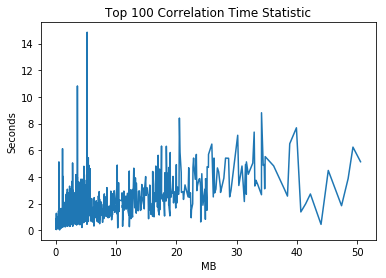

In [23]:
dtime = time_df(time_list,plot=True,title='Top 100 Correlation Time Statistic',save_path=path+'correlation_time_statistics.csv')

In [26]:
dtime['duration s'].describe()

count    2589.000000
mean        1.229705
std         1.119045
min         0.024918
25%         0.449797
50%         0.879518
75%         1.595126
max        14.855799
Name: duration s, dtype: float64

In [27]:
df = df_means.copy()
threshold_corr = 0.4
for c in df_means.columns:
    cor_idx = df[c] >=  threshold_corr
    noncor_idx = (df[c] <= threshold_corr) 
    df.loc[cor_idx , c] = 1
    df.loc[noncor_idx , c] = 0

Save corr_networkx_graph.pickle successfully.


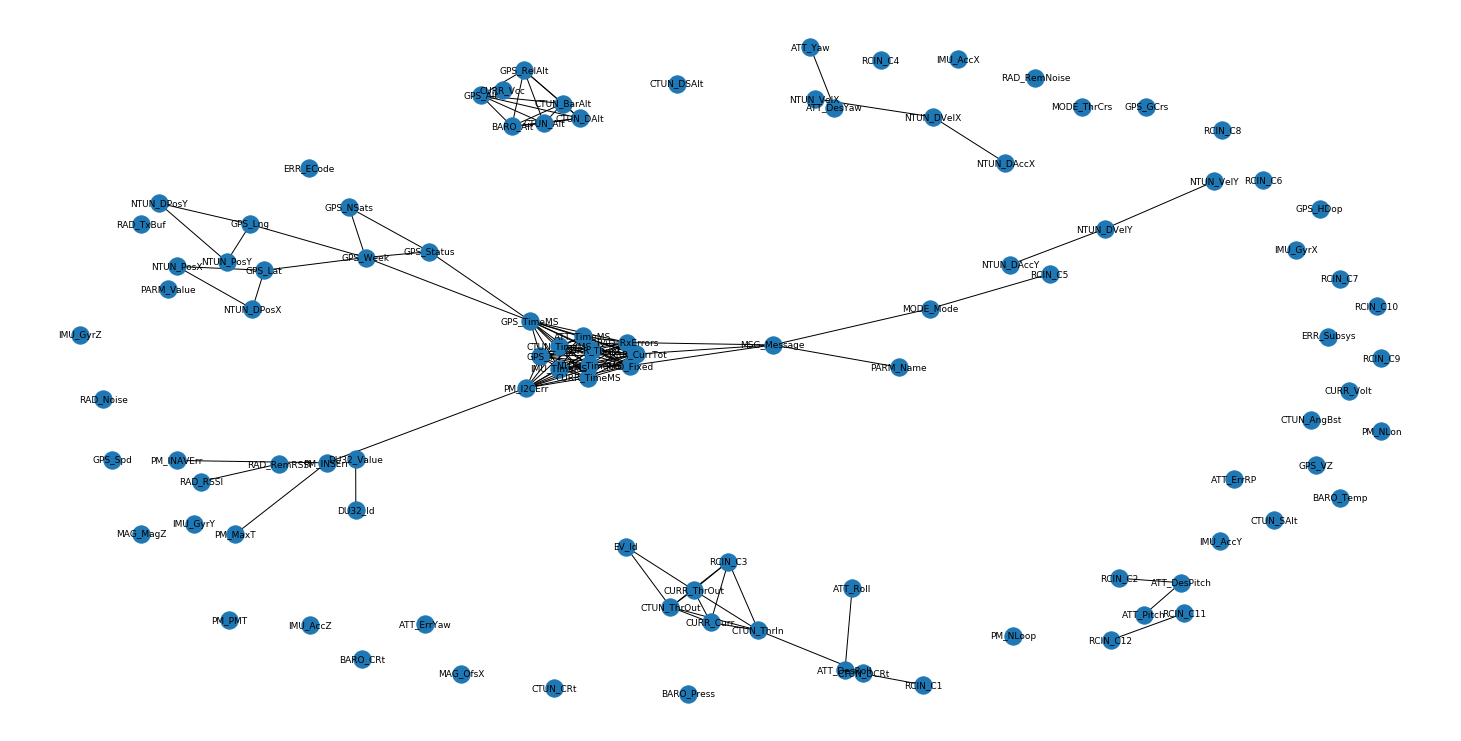

In [28]:
G = nx.Graph()
G.add_nodes_from(df.columns)
for idx in df.index:
    ltuples = [(idx,cl) for cl in df.columns[df.loc[idx] == 1] if cl != idx]
    G.add_edges_from(ltuples)
#create tuples
save_as_pickle(G,'../stats_files','corr_networkx_graph.pickle') #saving the graph to be used later for analysis
pos = nx.spring_layout(G,k=0.3,iterations=50)
plt.figure(figsize=(20,10))
nx.draw(G,with_labels=True,font_size=9,pos=pos)
plt.draw()
plt.show()

In [29]:
stat_in_out = []
for c in df.columns:
    c_count = len(G.edges(c))
    stat_in_out.append((c,c_count))
df_inout = pd.DataFrame(stat_in_out,columns=['signal','corr_count'])

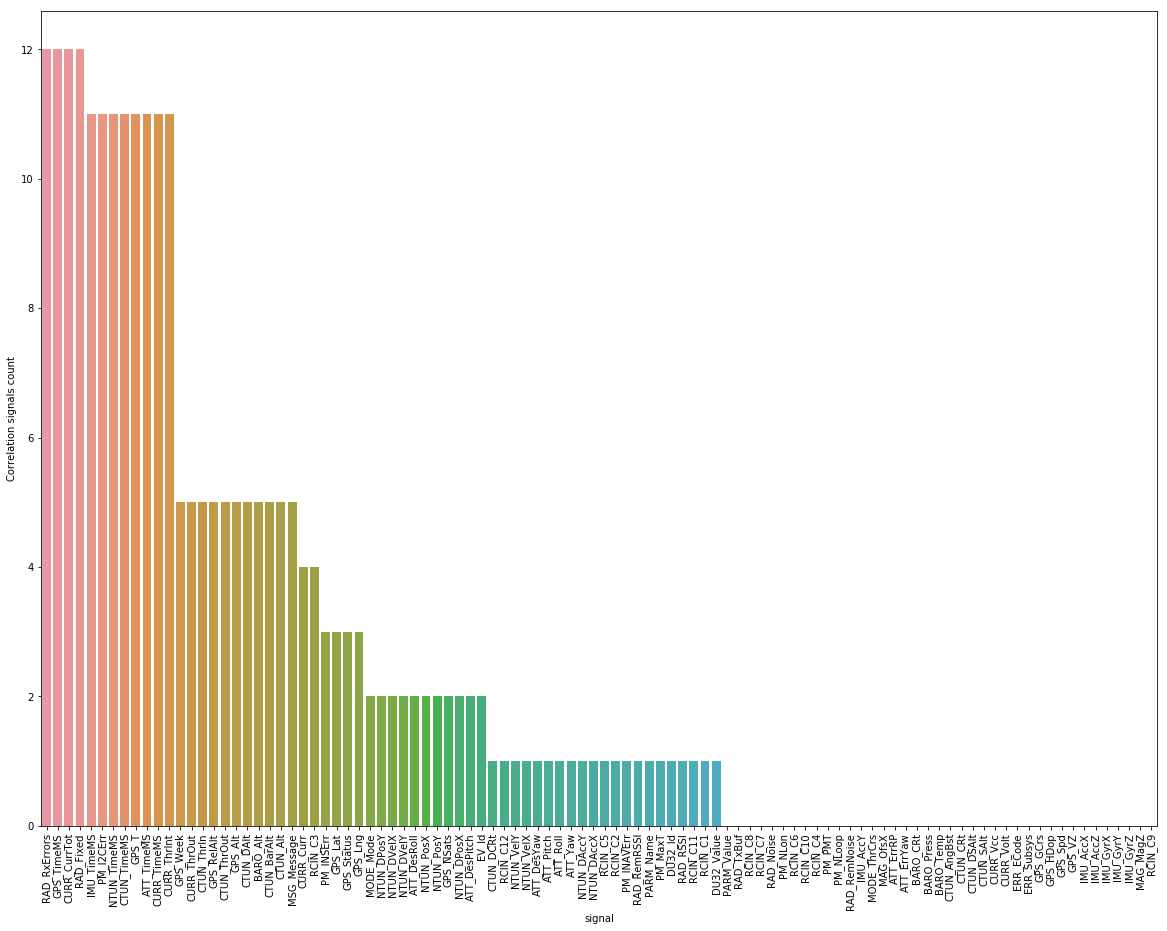

In [31]:
plt.figure(figsize=(20,15))
g = sns.barplot(x='signal',y='corr_count',data=df_inout.sort_values('corr_count',ascending=False))
g.set_xticklabels(labels=df_inout.sort_values('corr_count',ascending=False).signal,rotation=90)
plt.ylabel('Correlation signals count')
plt.show()
figure = g.get_figure()  
figure.savefig('../report/correlation_counts.png', dpi=500)